![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sarcasm Detection

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

In [2]:
pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,LSTM
from keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

### Load Data (3 Marks)

In [4]:
news = pd.read_json("/content/drive/My Drive/AIML/Sarcasm Detection/Data/Sarcasm_Headlines_Dataset.json", lines=True)
news.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Drop `article_link` from dataset (3 Marks)

In [5]:
news = news.drop(['article_link'], axis=1)
news.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


### Get length of each headline and add a column for that (3 Marks)

In [6]:
news['len'] = news['headline'].apply(lambda x: len(x.split(" ")))
news.head()

,headline,is_sarcastic,len
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


### Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [7]:
max_features = 10000
maxlen = 25
embedding_size = 200

### Apply `tensorflow.keras` Tokenizer and get indices for words (3 Marks)
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [8]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(news['headline']))
X = tokenizer.texts_to_sequences(news['headline'])

### Pad sequences (3 Marks)
- Pad each example with a maximum length
- Convert target column into numpy array

In [9]:
X = pad_sequences(X, maxlen = maxlen)
y = news['is_sarcastic']

### Vocab mapping
- There is no word for 0th index

In [10]:
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'trump': 12,
 'man': 13,
 'from': 14,
 'at': 15,
 'about': 16,
 'you': 17,
 'this': 18,
 'by': 19,
 'after': 20,
 'up': 21,
 'out': 22,
 'be': 23,
 'how': 24,
 'as': 25,
 'it': 26,
 'that': 27,
 'not': 28,
 'are': 29,
 'your': 30,
 'his': 31,
 'what': 32,
 'he': 33,
 'all': 34,
 'just': 35,
 'who': 36,
 'has': 37,
 'will': 38,
 'more': 39,
 'one': 40,
 'into': 41,
 'report': 42,
 'year': 43,
 'why': 44,
 'have': 45,
 'area': 46,
 'over': 47,
 'donald': 48,
 'u': 49,
 'day': 50,
 'says': 51,
 's': 52,
 'can': 53,
 'first': 54,
 'woman': 55,
 'time': 56,
 'like': 57,
 'her': 58,
 "trump's": 59,
 'old': 60,
 'no': 61,
 'get': 62,
 'off': 63,
 'an': 64,
 'life': 65,
 'people': 66,
 'obama': 67,
 'now': 68,
 'house': 69,
 'still': 70,
 "'": 71,
 'women': 72,
 'make': 73,
 'was': 74,
 'than': 75,
 'white': 76,
 'back': 77,
 'my': 78,
 'i': 79,
 'clinton': 80,
 'down': 81,
 'i

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [11]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

29657


### **Load Glove Word Embeddings (3 Marks)**

In [12]:
EMBEDDING_FILE = '/content/drive/My Drive/AIML/Sarcasm Detection/Data/glove.6B.200d.txt'

### Create embedding matrix

In [13]:
embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

### Define model (5 Marks)
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [14]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

### Compile the model (3 Marks)

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         5931400   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               51400     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

### Fit the model (4 Marks)

In [17]:
batch_size = 1000
epochs = 10
history = model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.3)

Epoch 1/10
19/19 [==============================] - 26s 1s/step - loss: 0.6839 - accuracy: 0.5458 - val_loss: 0.6516 - val_accuracy: 0.5719
Epoch 2/10
19/19 [==============================] - 26s 1s/step - loss: 0.5913 - accuracy: 0.6905 - val_loss: 0.4721 - val_accuracy: 0.7757
Epoch 3/10
19/19 [==============================] - 26s 1s/step - loss: 0.4356 - accuracy: 0.8183 - val_loss: 0.3913 - val_accuracy: 0.8219
Epoch 4/10
19/19 [==============================] - 28s 1s/step - loss: 0.3338 - accuracy: 0.8704 - val_loss: 0.3597 - val_accuracy: 0.8393
Epoch 5/10
19/19 [==============================] - 26s 1s/step - loss: 0.2601 - accuracy: 0.9038 - val_loss: 0.3649 - val_accuracy: 0.8501
Epoch 6/10
19/19 [==============================] - 26s 1s/step - loss: 0.1969 - accuracy: 0.9309 - val_loss: 0.3853 - val_accuracy: 0.8580
Epoch 7/10
19/19 [==============================] - 26s 1s/step - loss: 0.1445 - accuracy: 0.9536 - val_loss: 0.4109 - val_accuracy: 0.8586
Epoch 8/10
19/19 [==

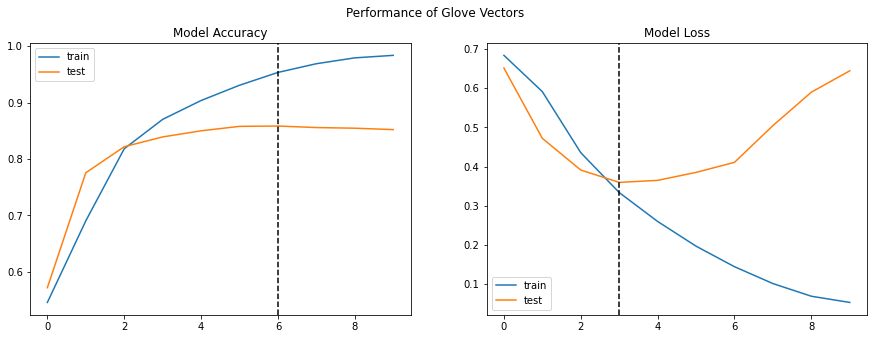

In [18]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
fig.suptitle("Performance of Glove Vectors")
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
vline_cut = np.where(history.history['val_accuracy'] == np.max(history.history['val_accuracy']))[0][0]
ax1.axvline(x=vline_cut, color='k', linestyle='--')
ax1.set_title("Model Accuracy")
ax1.legend(['train', 'test'])

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
vline_cut = np.where(history.history['val_loss'] == np.min(history.history['val_loss']))[0][0]
ax2.axvline(x=vline_cut, color='k', linestyle='--')
ax2.set_title("Model Loss")
ax2.legend(['train', 'test'])
plt.show()
